In [1]:
import os
os.chdir("../../../../")

In [2]:
os.environ['CUDA_VISIBLE_DEVICES']=str(2)

In [3]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import optax
import pandas as pd
from functools import partial
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from utilities.fits import fit
from datasets.dataset_loader import dataset_load
from utilities import plot, gmm, errors, predict, preprocess
from models import lstm

In [4]:
from jax.flatten_util import ravel_pytree
import blackjax
from probml_utils.blackjax_utils import inference_loop

In [5]:
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions

In [6]:
train ={ 
    1: {
          'start_time': "2011-04-28" ,
          'end_time': "2011-05-15"
        },
    3: {
          'start_time': "2011-04-19" ,
          'end_time': "2011-05-22"
    }
}
test = {
     2: {
          'start_time': "2011-04-21" ,
          'end_time': "2011-05-21"
    }
}
appliances = ["Dish Washer"]

In [7]:
datas = dataset_load(appliances, train, test, 19,split_factor=0.25)
x_train, y_train = datas[0], datas[1]
x_cal, y_cal = datas[2], datas[3]
x_test,y_test = datas[4],datas[5]
x_test_timestamp = datas[6]
scaler_x, scaler_y = datas[7], datas[8]

In [8]:
training_predictions_df = pd.DataFrame()
testing_predictions_df = pd.DataFrame()
calibration_predictions_df = pd.DataFrame()
training_predictions_df["Ground Truth"] = scaler_y.inverse_transform(y_train)[:,0]
calibration_predictions_df['Ground Truth']=scaler_y.inverse_transform(y_cal)[:,0]
testing_predictions_df["Timestamp"] = x_test_timestamp
testing_predictions_df["Ground Truth"] = y_test


## Seq2point

In [9]:
model = lstm.lstm_mlp()

In [10]:
%%capture cap --no-stderr
%%time
params =  model.init(jax.random.PRNGKey(0), x_train, True)
params, losses = fit(model, params, x_train, y_train, False, batch_size=1024, learning_rate=0.0001, epochs=50)

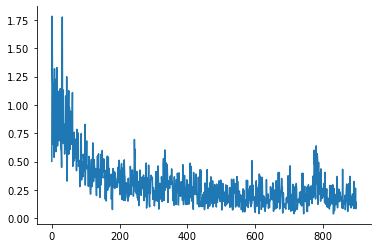

In [11]:
plt.plot(losses)
sns.despine()

In [12]:
mlp_training_time = cap.stdout.split('\n')[1]
mlp_training_time

'Wall time: 37 s'

#### Training Results

In [13]:
y_hat = model.apply(params, x_train, True, rngs={"dropout":jax.random.PRNGKey(0)})

In [14]:
y_hat = scaler_y.inverse_transform(y_hat)
y_true = scaler_y.inverse_transform(y_train)

In [15]:
print(f"RMSE : {errors.rmse(y_true, y_hat):.4f} MAE  : {errors.mae(y_true, y_hat):.4f}")

RMSE : 38.3278 MAE  : 9.0635


In [16]:
training_predictions_df['mean']=y_hat[:,0]

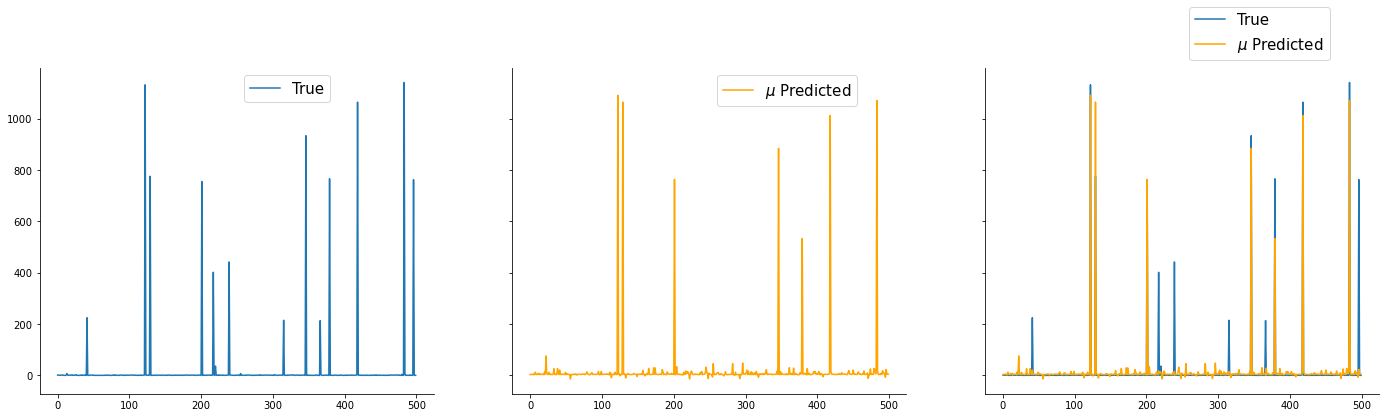

In [17]:
idx1 = 0
idx2 = 500
fig, ax = plt.subplots(1, 3, figsize=(24,6),sharey='row')
ax[0].plot(y_true[idx1:idx2], label="True")
ax[1].plot(y_hat[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[2].plot(y_true[idx1:idx2], label="True")
ax[2].plot(y_hat[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[0].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[1].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[2].legend(fontsize=15, bbox_to_anchor=(0.5,1))
sns.despine()

#### Calibration Set Results

In [18]:
y_hat_cal = model.apply(params, x_cal, True, rngs={"dropout":jax.random.PRNGKey(0)})

In [19]:
y_hat_cal = scaler_y.inverse_transform(y_hat_cal)
y_true_cal = scaler_y.inverse_transform(y_cal)

In [20]:
print(f"RMSE : {errors.rmse(y_true_cal, y_hat_cal):.4f} MAE  : {errors.mae(y_true_cal, y_hat_cal):.4f}")

RMSE : 47.1850 MAE  : 9.7444


In [21]:
calibration_predictions_df['mean']=y_hat_cal[:,0]

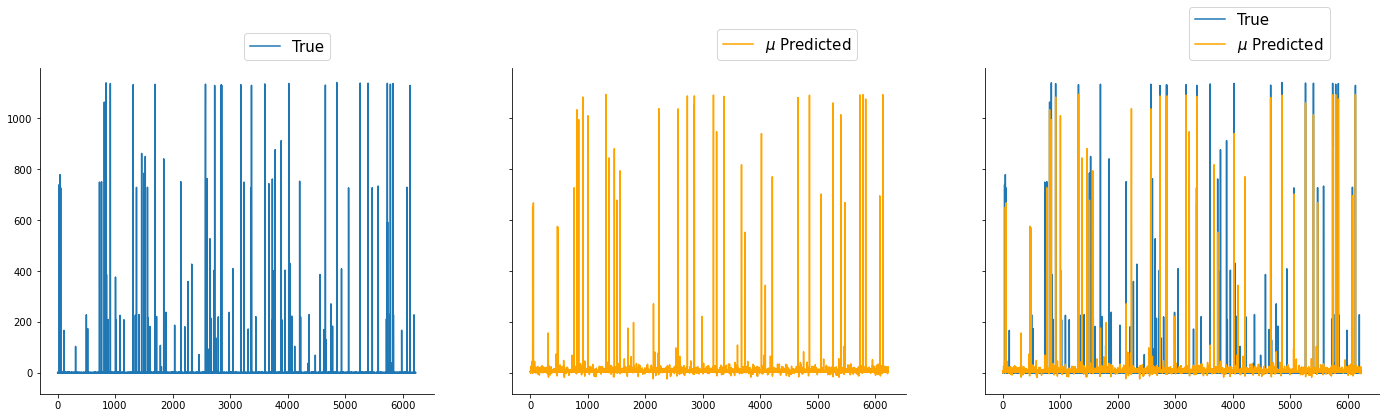

In [22]:
idx1 = 0
idx2 = -1
fig, ax = plt.subplots(1, 3, figsize=(24,6),sharey='row')
ax[0].plot(y_true_cal[idx1:idx2], label="True")
ax[1].plot(y_hat_cal[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[2].plot(y_true_cal[idx1:idx2], label="True")
ax[2].plot(y_hat_cal[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[0].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[1].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[2].legend(fontsize=15, bbox_to_anchor=(0.5,1))
sns.despine()

#### Testing Results

In [23]:
%%capture cap
%%time
y_hat = model.apply(params, x_test, True, rngs={"dropout":jax.random.PRNGKey(0)})
y_hat = scaler_y.inverse_transform(y_hat)

In [24]:
mlp_testing_time = cap.stdout.split('\n')[1]

In [25]:
testing_predictions_df["mean"] = y_hat

In [26]:
print(f"RMSE : {errors.rmse(y_test, y_hat):.4f}\nMAE  : {errors.mae(y_test,y_hat):.4f}")

RMSE : 68.5940
MAE  : 12.2927


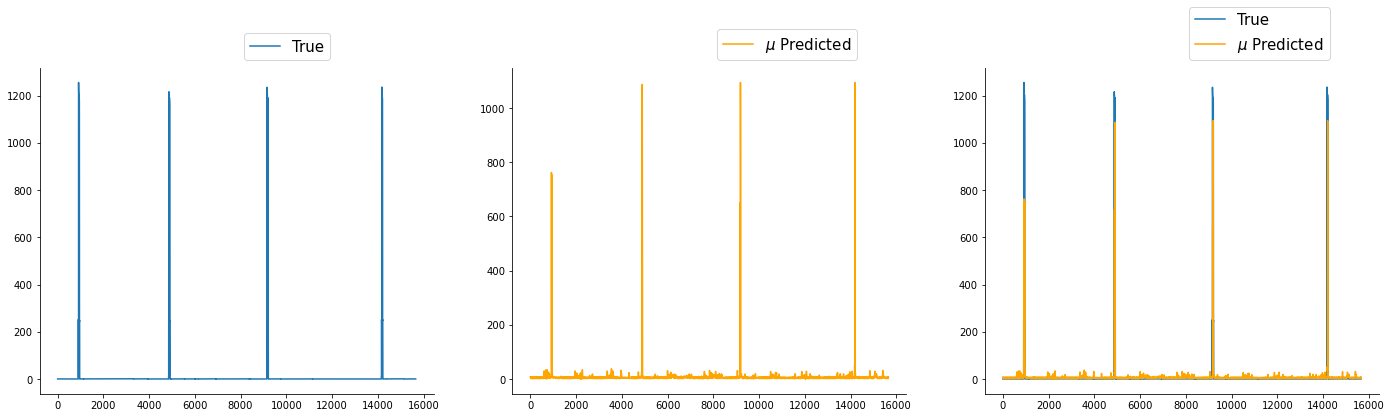

In [27]:
idx1 = 0
idx2 = -1
fig, ax = plt.subplots(1, 3, figsize=(24,6))
ax[0].plot(y_test[idx1:idx2], label="True")
ax[1].plot(y_hat[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[2].plot(y_test[idx1:idx2], label="True")
ax[2].plot(y_hat[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[0].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[1].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[2].legend(fontsize=15, bbox_to_anchor=(0.5,1))
sns.despine()

## MC Dropout

In [28]:
n_stacks = 10
fn = lambda x, i : model.apply(params, x, False, rngs={"dropout": jax.random.PRNGKey(i)})

#### Training Results

In [29]:
y_stacks = jax.vmap(jax.jit(fn), in_axes=(None, 0))(x_train, jnp.arange(n_stacks))

In [30]:
mc_train_mean =  y_stacks.mean(axis=0)
mc_train_sigma = y_stacks.std(axis=0)

In [31]:
mc_train_mean = scaler_y.inverse_transform(mc_train_mean)
mc_train_sigma = (scaler_y.scale_*mc_train_sigma)

In [32]:
print(f"RMSE : {errors.rmse(y_true, mc_train_mean):.4f}", f"MAE  : {errors.mae(y_true, mc_train_mean):.4f}", 
      f"NLL  : {errors.NLL(mc_train_mean, mc_train_sigma, y_true):.4f}")

RMSE : 38.4042 MAE  : 9.0712 NLL  : 438.4633


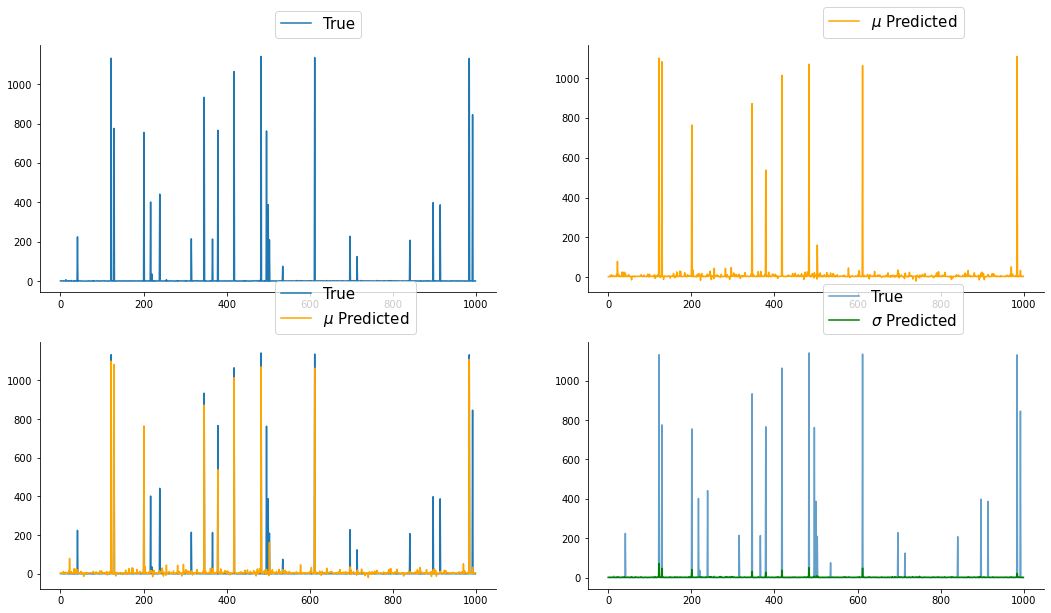

In [33]:
idx1 = 0
idx2 = 1000
fig, ax = plt.subplots(2, 2, figsize=(18,10))
ax = ax.ravel()
ax[0].plot(y_true[idx1:idx2], label="True")
ax[1].plot(mc_train_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[2].plot(y_true[idx1:idx2], label="True")
ax[2].plot(mc_train_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[3].plot(y_true[idx1:idx2], label="True", alpha=0.7)
ax[3].plot(mc_train_sigma[idx1:idx2], label=f"$\sigma$ Predicted", color="green")
ax[0].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[1].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[2].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[3].legend(fontsize=15, bbox_to_anchor=(0.5,1))
sns.despine()

In [34]:
training_predictions_df['MC_mean']=mc_train_mean
training_predictions_df['MC_sigma']=mc_train_sigma

In [35]:
training_predictions_df.head()

,Ground Truth,mean,MC_mean,MC_sigma
0,1.000000e+00,2.799903,2.878204,0.807478
1,1.000000e+00,3.600030,2.798518,0.982370
2,1.000000e+00,4.250433,4.220189,0.902021
3,8.209751e-08,3.020609,2.715200,0.890065
4,6.875001e-01,5.105176,4.725218,0.493914


#### Calibration Set Results

In [36]:
y_stacks = jax.vmap(jax.jit(fn), in_axes=(None, 0))(x_cal, jnp.arange(n_stacks))

In [37]:
mc_cal_mean =  y_stacks.mean(axis=0)
mc_cal_sigma = y_stacks.std(axis=0)

In [38]:
mc_cal_mean = scaler_y.inverse_transform(mc_cal_mean)
mc_cal_sigma = (scaler_y.scale_*mc_cal_sigma)

In [39]:
print(f"RMSE : {errors.rmse(y_true_cal, mc_cal_mean):.4f}", f"MAE  : {errors.mae(y_true_cal, mc_cal_mean):.4f}", 
      f"NLL  : {errors.NLL(mc_cal_mean, mc_cal_sigma, y_true_cal):.4f}")

RMSE : 47.1525 MAE  : 9.7953 NLL  : 387.6113


In [40]:
calibration_predictions_df['MC_Mean'] =mc_cal_mean
calibration_predictions_df['MC_Sigma'] =mc_cal_sigma

#### Testing Results

In [41]:
%%capture cap
%%time
y_stacks = jax.vmap(jax.jit(fn), in_axes=(None, 0))(x_test, jnp.arange(n_stacks))

In [42]:
mc_testing_time = cap.stdout.split('\n')[1]
mc_testing_time

'Wall time: 1.75 s'

In [43]:
mc_test_mean =  y_stacks.mean(axis=0)
mc_test_sigma = y_stacks.std(axis=0)

In [44]:
mc_test_mean = scaler_y.inverse_transform(mc_test_mean)
mc_test_sigma = (scaler_y.scale_*mc_test_sigma)

In [45]:
print(f"RMSE : {errors.rmse(y_test, mc_test_mean):.4f}", f"MAE  : {errors.mae(y_test, mc_test_mean):.4f}", 
      f"NLL  : {errors.NLL(mc_test_mean, mc_test_sigma, y_test):.4f}")

RMSE : 68.5884 MAE  : 12.2951 NLL  : 1014.7230


In [46]:
testing_predictions_df['MC_Mean'] =  mc_test_mean
testing_predictions_df['MC_Sigma'] = mc_test_sigma

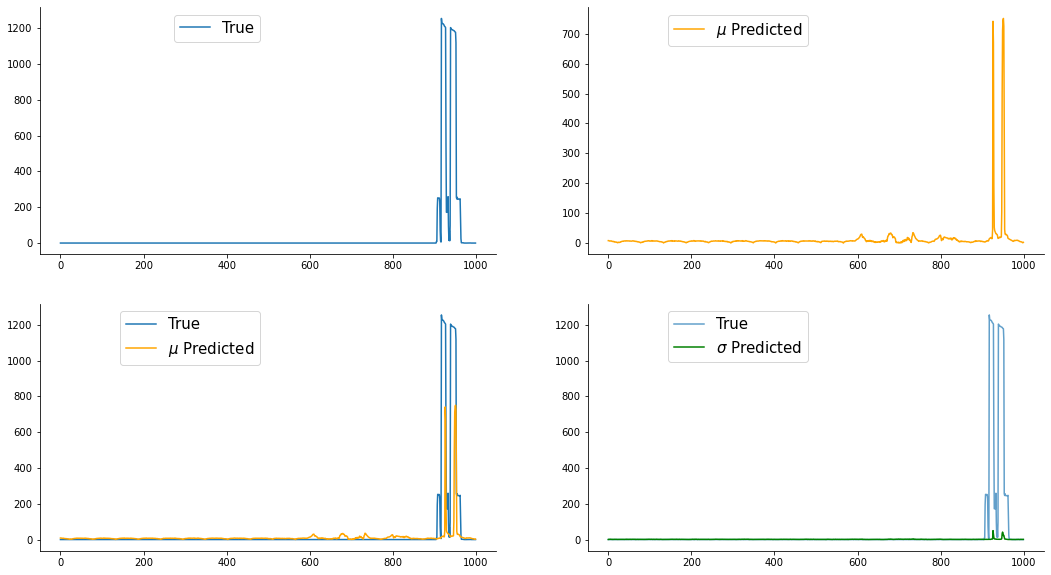

In [47]:
idx1 = 0
idx2 = 1000
fig, ax = plt.subplots(2, 2, figsize=(18,10))
ax = ax.ravel()
ax[0].plot(y_test[idx1:idx2], label="True")
ax[1].plot(mc_test_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[2].plot(y_test[idx1:idx2], label="True")
ax[2].plot(mc_test_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[3].plot(y_test[idx1:idx2], label="True", alpha=0.7)
ax[3].plot(mc_test_sigma[idx1:idx2], label=f"$\sigma$ Predicted", color="green")
ax[0].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[1].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[2].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[3].legend(fontsize=15, bbox_to_anchor=(0.5,1))
sns.despine()

### Calibration

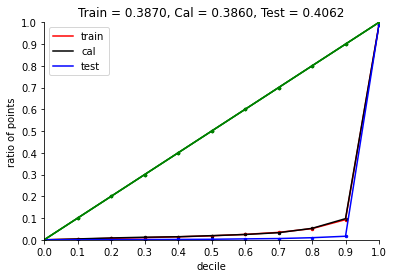

In [48]:
fig, ax = plt.subplots(1)
df, df1 = plot.calibration_regression(mc_train_mean.squeeze(), mc_train_sigma.squeeze(), 
                                     y_true.squeeze(), "train", "r", ax)
df, df2 = plot.calibration_regression(mc_cal_mean.squeeze(), mc_cal_sigma.squeeze(), 
                                      y_true_cal.squeeze(), "cal", "black", ax)
df, df3 = plot.calibration_regression(mc_test_mean.squeeze(), mc_test_sigma.squeeze(), 
                                      y_test.squeeze(), "test", "b", ax)

_ = ax.set_title(f'Train = {errors.ace(df1):.4f}, Cal = {errors.ace(df2):.4f}, Test = {errors.ace(df3):.4f}')
ax.legend()

## Deep Ensemble

In [49]:
def de_train(x, y, i, model):
    param =  model.init(jax.random.PRNGKey(i),x_train, True)
    param, losses = fit(model, param, x, y, False, batch_size=1024, 
                      learning_rate=0.0001, epochs=50)
    return param, losses
    
de_train = jax.tree_util.Partial(de_train, model=model)

def predict(x, param, model):
    yhat = model.apply(param,x,True)
    return yhat
test_ = jax.tree_util.Partial(predict, model=model)

In [50]:
%%capture cap
%%time
params_list, losses_list = jax.jit(jax.vmap(de_train, in_axes=(None, None, 0)))(x_train, y_train, jnp.arange(10))

In [51]:
de_training_time = cap.stdout.split('\n')[1]
de_training_time

'Wall time: 1min 46s'

#### Training Results

In [52]:
y_stacks = jax.jit(jax.vmap(test_, in_axes=(None,0)))(x_train, params_list)
de_train_mean = y_stacks.mean(axis=0)
de_train_sigma= y_stacks.std(axis=0)

In [53]:
de_train_mean = scaler_y.inverse_transform(de_train_mean)
de_train_sigma = (scaler_y.scale_*de_train_sigma)


In [54]:
print(f"RMSE : {errors.rmse(y_true, de_train_mean):.4f}", 
      f"MAE  : {errors.mae(y_true, de_train_mean):.4f}", 
      f"NLL  : {errors.NLL(de_train_mean, de_train_sigma, y_true):.4f}")

RMSE : 40.3619 MAE  : 7.6177 NLL  : 65.8551


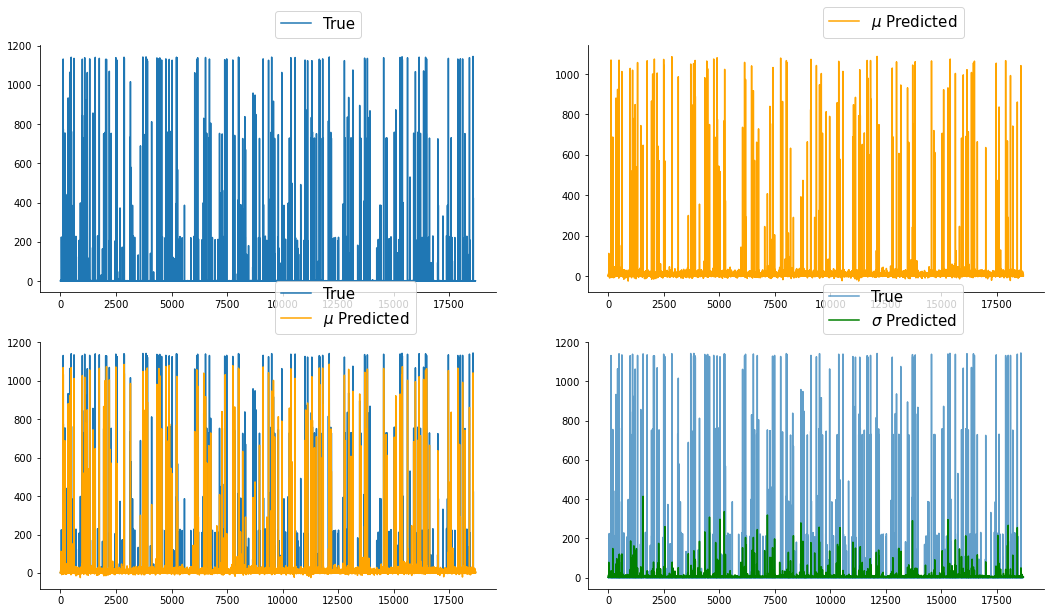

In [55]:
idx1 = 0
idx2 = -1
fig, ax = plt.subplots(2, 2, figsize=(18,10))
ax = ax.ravel()
ax[0].plot(y_true[idx1:idx2], label="True")
ax[1].plot(de_train_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[2].plot(y_true[idx1:idx2], label="True")
ax[2].plot(de_train_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[3].plot(y_true[idx1:idx2], label="True", alpha=0.7)
ax[3].plot(de_train_sigma[idx1:idx2], label=f"$\sigma$ Predicted", color="green")
ax[0].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[1].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[2].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[3].legend(fontsize=15, bbox_to_anchor=(0.5,1))
sns.despine()

In [56]:
training_predictions_df['DE_mean']=de_train_mean
training_predictions_df['DE_sigma']=de_train_sigma

#### Calibration Set Results

In [57]:
y_stacks = jax.jit(jax.vmap(test_, in_axes=(None,0)))(x_cal, params_list)
de_cal_mean = y_stacks.mean(axis=0)
de_cal_sigma= y_stacks.std(axis=0)

In [58]:
de_cal_mean = scaler_y.inverse_transform(de_cal_mean)
de_cal_sigma = (scaler_y.scale_*de_cal_sigma)



In [59]:
print(f"RMSE : {errors.rmse(y_true_cal, de_cal_mean):.4f}", 
      f"MAE  : {errors.mae(y_true_cal, de_cal_mean):.4f}", 
      f"NLL  : {errors.NLL(de_cal_mean, de_cal_sigma, y_true_cal):.4f}")

RMSE : 48.9840 MAE  : 8.3613 NLL  : 50.6592


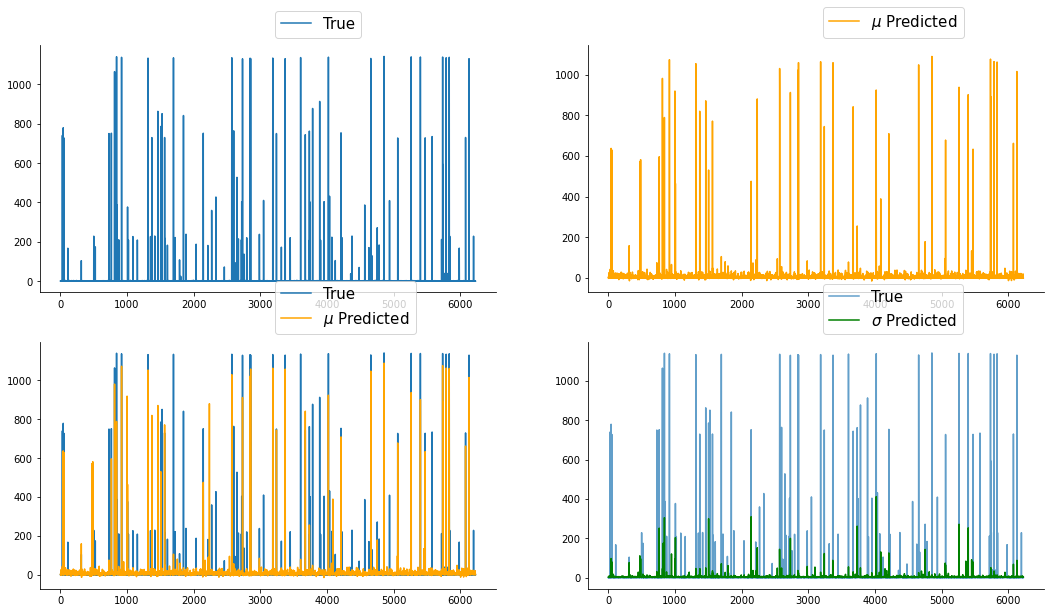

In [60]:
idx1 = 0
idx2 = -1
fig, ax = plt.subplots(2, 2, figsize=(18,10))
ax = ax.ravel()
ax[0].plot(y_true_cal[idx1:idx2], label="True")
ax[1].plot(de_cal_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[2].plot(y_true_cal[idx1:idx2], label="True")
ax[2].plot(de_cal_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[3].plot(y_true_cal[idx1:idx2], label="True", alpha=0.7)
ax[3].plot(de_cal_sigma[idx1:idx2], label=f"$\sigma$ Predicted", color="green")
ax[0].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[1].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[2].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[3].legend(fontsize=15, bbox_to_anchor=(0.5,1))
sns.despine()

In [61]:
calibration_predictions_df['DE_mean']=de_cal_mean
calibration_predictions_df['DE_sigma']=de_cal_sigma

In [62]:
calibration_predictions_df.head()

,Ground Truth,mean,MC_Mean,MC_Sigma,DE_mean,DE_sigma
0,8.209751e-08,2.966116,2.299294,0.733758,0.274720,2.092117
1,8.209751e-08,2.559615,1.745443,0.815659,0.464735,1.674974
2,1.000000e+00,4.071999,4.059705,1.319027,1.426056,2.081572
3,8.209751e-08,8.169722,7.782696,0.800294,6.656207,1.512911
4,9.375001e-01,2.059679,2.557539,1.201548,0.274061,1.614601


#### Testing Results

In [63]:
%%capture cap
%%time
y_stacks = jax.jit(jax.vmap(test_, in_axes=(None,0)))(x_test, params_list)

In [64]:
de_testing_time = cap.stdout.split('\n')[1]
de_testing_time

'Wall time: 1.76 s'

In [65]:
de_test_mean = y_stacks.mean(axis=0)
de_test_sigma= y_stacks.std(axis=0)

In [66]:
de_test_mean = scaler_y.inverse_transform(de_test_mean)
de_test_sigma = (scaler_y.scale_*de_test_sigma)

In [67]:
testing_predictions_df['de_Mean'] =  de_test_mean
testing_predictions_df['de_Sigma'] = de_test_sigma

In [68]:
print(f"RMSE : {errors.rmse(y_test, de_test_mean):.4f}", f"MAE  : {errors.mae(y_test, de_test_mean):.4f}", 
      f"NLL  : {errors.NLL(de_test_mean, de_test_sigma, y_test):.4f}")

RMSE : 70.2599 MAE  : 10.3316 NLL  : 230.3064


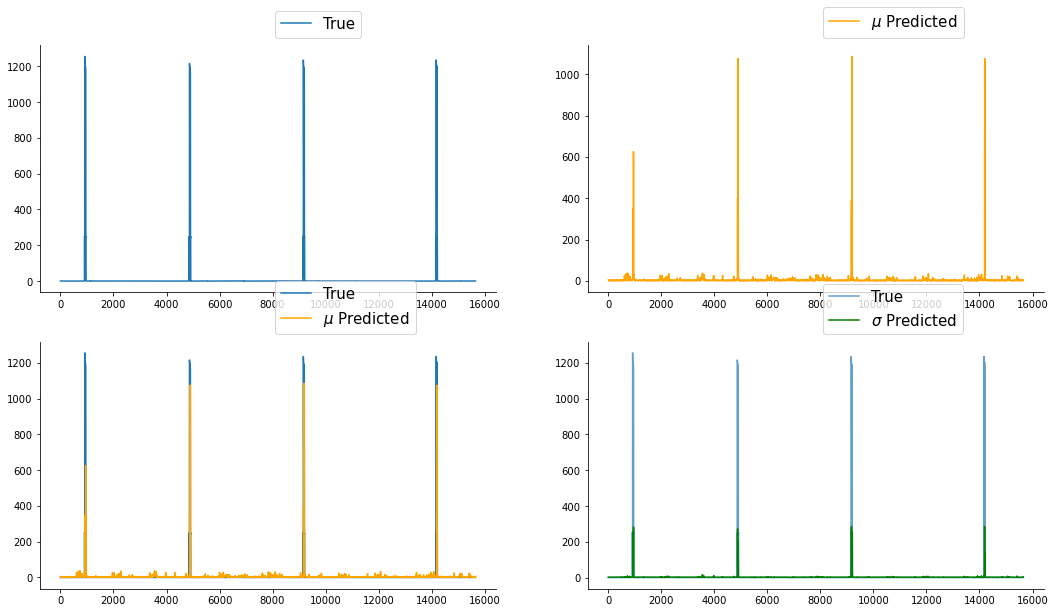

In [69]:
idx1 = 0
idx2 = -1
fig, ax = plt.subplots(2, 2, figsize=(18,10))
ax = ax.ravel()
ax[0].plot(y_test[idx1:idx2], label="True")
ax[1].plot(de_test_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[2].plot(y_test[idx1:idx2], label="True")
ax[2].plot(de_test_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[3].plot(y_test[idx1:idx2], label="True", alpha=0.7)
ax[3].plot(de_test_sigma[idx1:idx2], label=f"$\sigma$ Predicted", color="green")
ax[0].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[1].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[2].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[3].legend(fontsize=15, bbox_to_anchor=(0.5,1))
sns.despine()

### Calibration

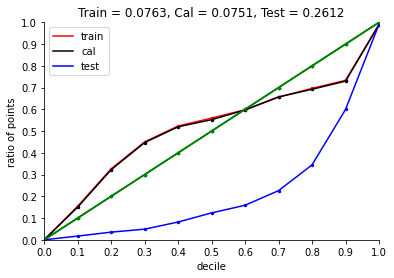

In [70]:
fig, ax = plt.subplots(1)
df, df1 = plot.calibration_regression(de_train_mean.squeeze(), de_train_sigma.squeeze(), 
                                     y_true.squeeze(), "train", "r", ax)
df, df2 = plot.calibration_regression(de_cal_mean.squeeze(), de_cal_sigma.squeeze(), 
                                      y_true_cal.squeeze(), "cal", "black", ax)
df, df3 = plot.calibration_regression(de_test_mean.squeeze(), de_test_sigma.squeeze(), 
                                      y_test.squeeze(), "test", "b", ax)

_ = ax.set_title(f'Train = {errors.ace(df1):.4f}, Cal = {errors.ace(df2):.4f}, Test = {errors.ace(df3):.4f}')
ax.legend()

## Bootstrap

In [71]:
def bs_train(x, y, i, model):
    idx = jax.random.choice(jax.random.PRNGKey(i), jnp.arange(len(x)), (len(x),))
    new_x, new_y = x[idx], y[idx]
    param =  model.init(jax.random.PRNGKey(i),x_train, True)
    param, losses = fit(model, param, new_x, new_y, True, batch_size=1024, 
                      learning_rate=0.0001, epochs= 50)
    return param, losses

bs_train = jax.tree_util.Partial(bs_train, model=model)

In [72]:
%%capture cap
%%time
params_list, losses_list = jax.jit(jax.vmap(bs_train, in_axes=(None, None, 0)))(x_train, y_train, jnp.arange(10))

In [73]:
bs_training_time = cap.stdout.split('\n')[1]
bs_training_time

'Wall time: 1min 48s'

#### Training Results

In [74]:
y_stacks = jax.jit(jax.vmap(test_, in_axes=(None,0)))(x_train, params_list)
bs_train_mean = y_stacks.mean(axis=0)
bs_train_sigma= y_stacks.std(axis=0)

In [75]:
bs_train_mean = scaler_y.inverse_transform(bs_train_mean)
bs_train_sigma = scaler_y.scale_*bs_train_sigma

In [76]:
y_train.shape

(18688, 1)

In [77]:
print(f"RMSE : {errors.rmse(y_true, bs_train_mean):.4f}", 
      f"MAE  : {errors.mae(y_true, bs_train_mean):.4f}", 
      f"NLL  : {errors.NLL(bs_train_mean, bs_train_sigma, y_true):.4f}")

RMSE : 39.7567 MAE  : 7.7707 NLL  : 30.0666


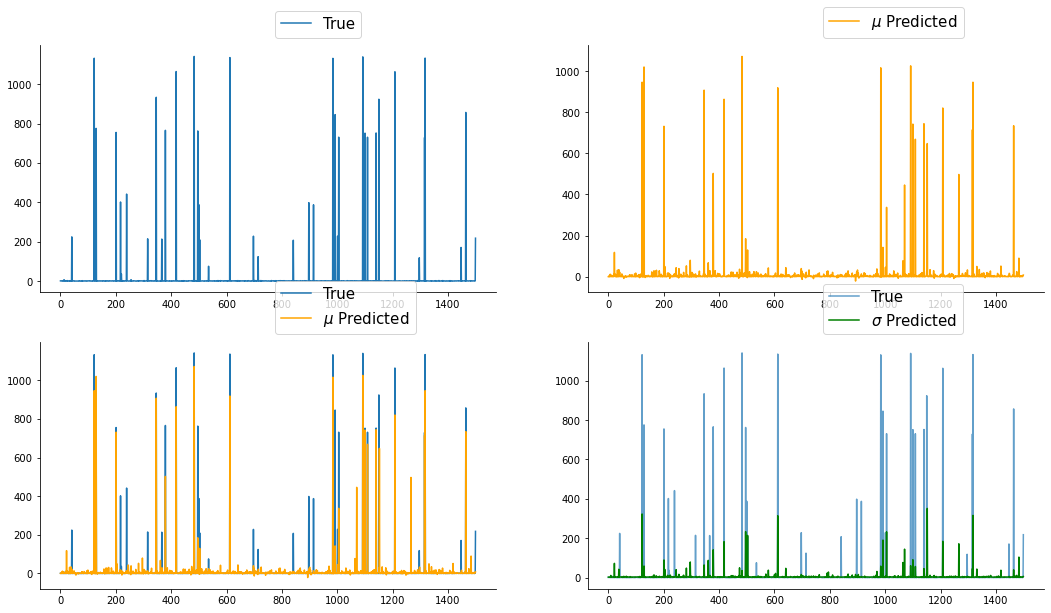

In [78]:
idx1 = 0
idx2 = 1500
fig, ax = plt.subplots(2, 2, figsize=(18,10))
ax = ax.ravel()
ax[0].plot(y_true[idx1:idx2], label="True")
ax[1].plot(bs_train_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[2].plot(y_true[idx1:idx2], label="True")
ax[2].plot(bs_train_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[3].plot(y_true[idx1:idx2], label="True", alpha=0.7)
ax[3].plot(bs_train_sigma[idx1:idx2], label=f"$\sigma$ Predicted", color="green")
ax[0].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[1].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[2].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[3].legend(fontsize=15, bbox_to_anchor=(0.5,1))
sns.despine()

In [79]:
training_predictions_df['BS_mean']=bs_train_mean
training_predictions_df['BS_sigma']=bs_train_sigma

#### Calibration Set Results

In [80]:
y_stacks = jax.jit(jax.vmap(test_, in_axes=(None,0)))(x_cal, params_list)
bs_cal_mean = y_stacks.mean(axis=0)
bs_cal_sigma= y_stacks.std(axis=0)

In [81]:
bs_cal_mean = scaler_y.inverse_transform(bs_cal_mean)
bs_cal_sigma = scaler_y.scale_*bs_cal_sigma

In [82]:
print(f"RMSE : {errors.rmse(y_true_cal, bs_cal_mean):.4f}", 
      f"MAE  : {errors.mae(y_true_cal, bs_cal_mean):.4f}", 
      f"NLL  : {errors.NLL(bs_cal_mean, bs_cal_sigma, y_true_cal):.4f}")

RMSE : 47.5692 MAE  : 8.4465 NLL  : 22.8815


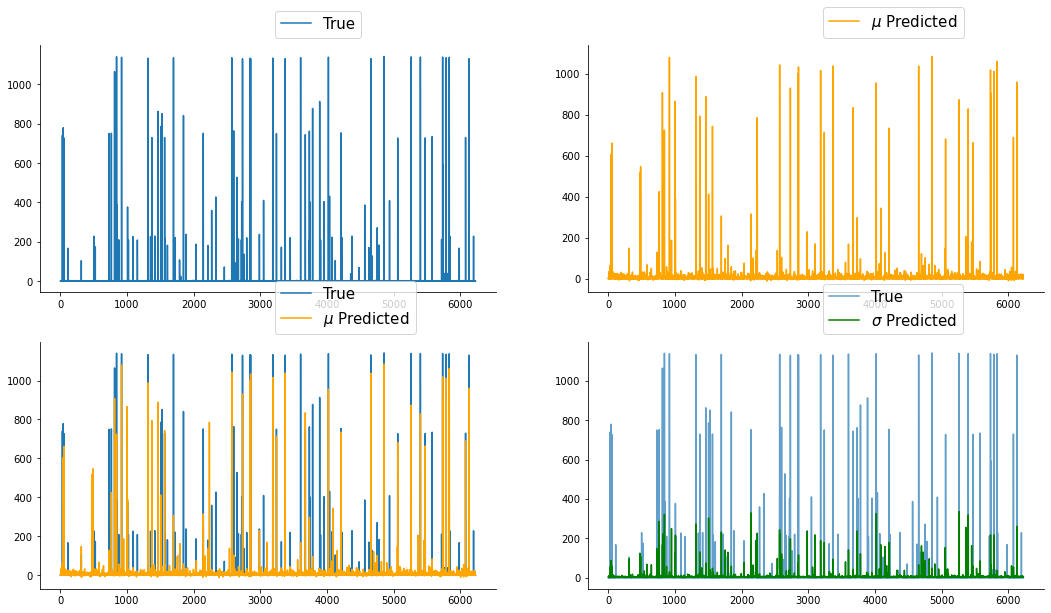

In [83]:
idx1 = 0
idx2 = -1
fig, ax = plt.subplots(2, 2, figsize=(18,10))
ax = ax.ravel()
ax[0].plot(y_true_cal[idx1:idx2], label="True")
ax[1].plot(bs_cal_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[2].plot(y_true_cal[idx1:idx2], label="True")
ax[2].plot(bs_cal_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[3].plot(y_true_cal[idx1:idx2], label="True", alpha=0.7)
ax[3].plot(bs_cal_sigma[idx1:idx2], label=f"$\sigma$ Predicted", color="green")
ax[0].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[1].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[2].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[3].legend(fontsize=15, bbox_to_anchor=(0.5,1))
sns.despine()

In [84]:
calibration_predictions_df['bs_Mean'] =  bs_cal_mean
calibration_predictions_df['bs_Sigma'] = bs_cal_sigma

#### Testing Results

In [85]:
%%capture cap
%%time
y_stacks = jax.jit(jax.vmap(test_, in_axes=(None, 0)))(x_test, params_list)

In [86]:
bs_testing_time = cap.stdout.split('\n')[1]
bs_testing_time

'Wall time: 1.67 s'

In [87]:
bs_test_mean = y_stacks.mean(axis=0)
bs_test_sigma= y_stacks.std(axis=0)

In [88]:
bs_test_mean = scaler_y.inverse_transform(bs_test_mean)
bs_test_sigma = scaler_y.scale_*bs_test_sigma

In [89]:
print(f"RMSE : {errors.rmse(y_test, bs_test_mean):.4f}", f"MAE  : {errors.mae(y_test, bs_test_mean):.4f}", 
      f"NLL  : {errors.NLL(bs_test_mean, bs_test_sigma, y_test):.4f}")

RMSE : 68.6247 MAE  : 9.9907 NLL  : 78.1146


In [90]:
testing_predictions_df['bs_Mean'] =  bs_test_mean
testing_predictions_df['bs_Sigma'] = bs_test_sigma

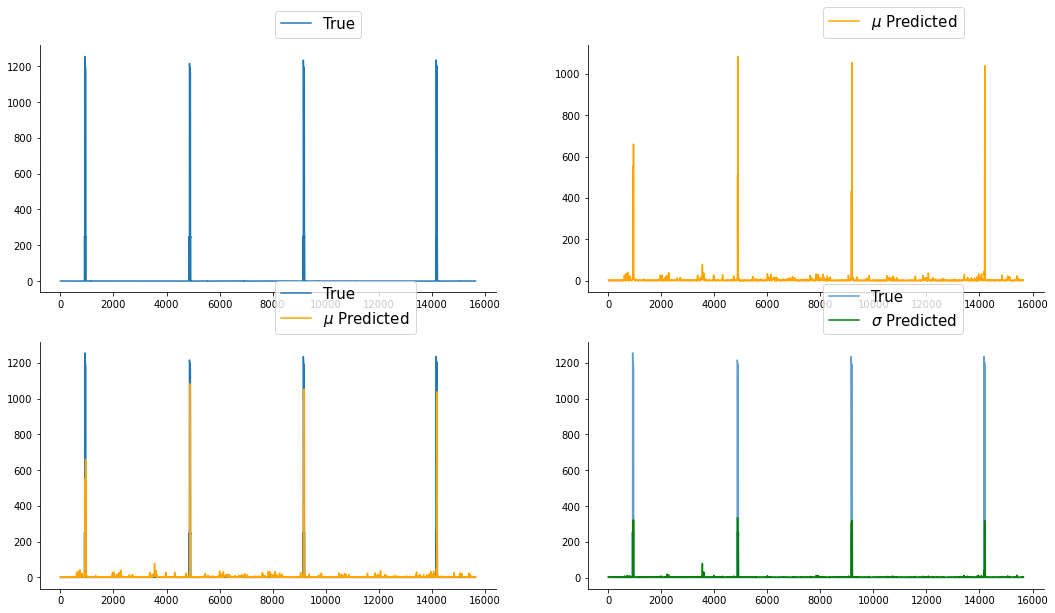

In [91]:
idx1 = 0
idx2 = -1
fig, ax = plt.subplots(2, 2, figsize=(18,10))
ax = ax.ravel()
ax[0].plot(y_test[idx1:idx2], label="True")
ax[1].plot(bs_test_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[2].plot(y_test[idx1:idx2], label="True")
ax[2].plot(bs_test_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[3].plot(y_test[idx1:idx2], label="True", alpha=0.7)
ax[3].plot(bs_test_sigma[idx1:idx2], label=f"$\sigma$ Predicted", color="green")
ax[0].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[1].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[2].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[3].legend(fontsize=15, bbox_to_anchor=(0.5,1))
sns.despine()

### Calibration

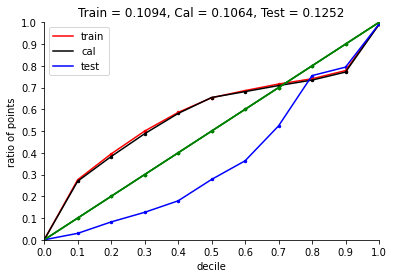

In [92]:
fig, ax = plt.subplots(1)
df, df1 = plot.calibration_regression(bs_train_mean.squeeze(), bs_train_sigma.squeeze(), 
                                     y_true.squeeze(), "train", "r", ax)
df, df2 = plot.calibration_regression(bs_cal_mean.squeeze(), bs_cal_sigma.squeeze(), 
                                      y_true_cal.squeeze(), "cal", "black", ax)
df, df3 = plot.calibration_regression(bs_test_mean.squeeze(), bs_test_sigma.squeeze(), 
                                      y_test.squeeze(), "test", "b", ax)

_ = ax.set_title(f'Train = {errors.ace(df1):.4f}, Cal = {errors.ace(df2):.4f}, Test = {errors.ace(df3):.4f}')
ax.legend()

## Save Results

In [93]:
training_predictions_df.to_csv("notebooks/dishwasher/lstm/mlp/training_predictions.csv",index=False)
calibration_predictions_df.to_csv("notebooks/dishwasher/lstm/mlp/calibration_predictions.csv",index=False)
testing_predictions_df.to_csv("notebooks/dishwasher/lstm/mlp/testing_predictions.csv",index=False)

In [94]:
with open('notebooks/dishwasher/lstm/mlp/time.txt', 'w') as file:
    file.writelines([f"MLP training :{mlp_training_time} ",f" MLP Testing : {mlp_testing_time}\n"
               f"MC Testing : {mc_testing_time}\n", 
               f"DE Training Time : {de_training_time} ",f" DE Testing Time: {de_testing_time}\n", 
               f"BS Training Time : {bs_training_time} ",f" BS Testing Time: {bs_testing_time}"])